# Tutorial 1 - Neural network intro

In this tutorial, we'll introduce the **Python** programming language and some of its libraries, most notably [PyTorch](https://pytorch.org/).

The approaches used by PyTorch are broadly applicable to other frameworks as well, such as [TensorFlow](https://www.tensorflow.org/), [JAX](https://docs.jax.dev/en/latest/), [Flux.jl](https://fluxml.ai/) or [Deep Learning Toolbox](https://www.mathworks.com/products/deep-learning.html).

For a more detailed overview of PyTorch you can also go through the [oficial tutorials](https://pytorch.org/tutorials/).

## Package installation with uv and Jupyter

We'll first install the [uv](https://docs.astral.sh/uv/) package manager. We can install Jupyter system-wide with uv by running:

```bash
$ uv tool install jupyterlab
```

We need to create a uv project and connect it to Jupyter:
```bash
$ uv init
$ uv add --dev ipykernel
$ uv run ipython kernel install --user --env VIRTUAL_ENV $(pwd)/.venv --name=tzn
```

In order for the newly installed Jupyter kernel to be available, we need to restart Jupyter.

Finally, we can install the required packages:
```bash
$ uv add matplotlib numpy scikit-learn torch torch-geometric torchvision
$ uv add torch-cluster -f https://data.pyg.org/whl/torch-2.8.0+cpu.html
```

## Task 1

Run the aforementioned steps to create a package and have the next cell run without errors. It should print something like `Torch version: 2.8.0`.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

print("Torch version:", torch.__version__)

Torch version: 2.8.0+cu128


## Tensors and working with them in PyTorch

Let's first take a look at how to create and manipulate tensors and what is happening in the background in order to automatically compute gradients. 

A tensor is in essence a name for an array with $n$ dimentisons - i. e. like the `ndarray` in numpy.

We can create a PyTorch tensor by converting from python or numpy:

In [2]:
a = torch.tensor([[1, 2], [3,4]])
print(a)

tensor([[1, 2],
        [3, 4]])


We can also convert it back to numpy:

In [3]:
print(a.numpy())

[[1 2]
 [3 4]]


A tensor always has the attributes `shape` and `dtype`:

In [4]:
print('Shape:', a.shape)
print('Element data type:', a.dtype)

Shape: torch.Size([2, 2])
Element data type: torch.int64


Other ways of constructing a tensor:

In [5]:
print(torch.ones((1, 3)))
print(torch.zeros((1, 3)))
print(torch.randn((1, 4))) # Normal distribution
print(torch.rand((1, 4))) # Uniform distribution on [0, 1)

tensor([[1., 1., 1.]])
tensor([[0., 0., 0.]])
tensor([[1.1132, 2.5485, 1.5703, 0.0552]])
tensor([[0.0648, 0.4012, 0.1246, 0.3300]])


We can do basic operations with PyTorch tensors. Let's construct three tensors with the same dtype:

In [6]:
a = torch.tensor([[1, 2], [3,4]], dtype = torch.float32)
b = torch.ones((2, 1))
c = torch.randn((2, 1))
print(a)
print(b)
print(c)

tensor([[1., 2.],
        [3., 4.]])
tensor([[1.],
        [1.]])
tensor([[1.2934],
        [0.4699]])


Matrix multiplication:

In [7]:
print(a.matmul(b))

tensor([[3.],
        [7.]])


Element-wise addition:

In [8]:
print(b.add(c))

tensor([[2.2934],
        [1.4699]])


Element-wise square:

In [9]:
print(a.square())

tensor([[ 1.,  4.],
        [ 9., 16.]])


Euclidean norm of a vector:

In [10]:
print(b.norm())

tensor(1.4142)


Matrix rank:

In [11]:
print(torch.linalg.matrix_rank(a))

tensor(2)


Element-wise application of the sine function:

In [12]:
print(torch.sin(a))

tensor([[ 0.8415,  0.9093],
        [ 0.1411, -0.7568]])


Boolean indicator of whether each element is greater than 1:

In [13]:
print(a.greater(1))

tensor([[False,  True],
        [ True,  True]])


## Task 2 - basics of working with data

Let's load the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset and calculate the average value of each feature. Running the next cell for the first time downloads the dataset and may take a while.

In [14]:
data = datasets.MNIST(
    root = "data",
    download = True,
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
)

We've loaded images from the MNIST dataset. Now try to calculate the average value of each feature accross all images. Use the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class.

## Solution

Our data have the following shape and data type:

In [15]:
display(data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
           )

In [16]:
print(data[0][0].shape)
print(data[0][0].dtype)
print(data[0][1]) # Label

torch.Size([1, 28, 28])
torch.float32
5


To make working with the data easier, let's load it with the `DataLoader` helper class:

In [17]:
dataloader = DataLoader(data, batch_size = 1)

Let's calculate the average of all images:

In [18]:
mean_image = torch.zeros(data[0][0].shape, dtype = data[0][0].dtype)

for image, _label in dataloader:
    mean_image += image[0, :, :, :] # First dimension is the batch, here of size 1

mean_image /= len(data)

Let's plot this with `matplotlib`:

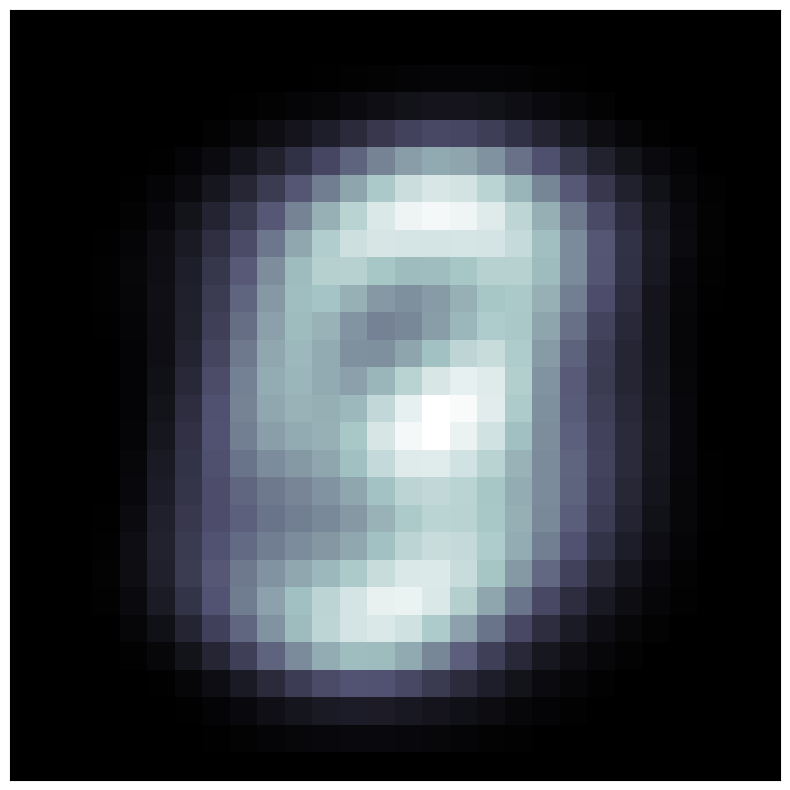

In [19]:
plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(torch.reshape(mean_image, [mean_image.shape[1], mean_image.shape[2]]), cmap = plt.cm.bone)

## Automatic gradient calculation

To automatically calculate gradients, we use the regular `torch.Tensor`. To calculate gradients with respect to some variable, we need to set it to `requires_grad = True`. This will make PyTorch track all operations which depend on this variable. To actually calculate the gradient, we need to call the `fun.backward()` method, which will calculate th derivative of `fun` with respect to all the input variables. If `fun` is of greater dimension than 1, we need to pass to `backward` a tensor with repspect to which to calculate the Jacobian.

In [20]:
x = torch.tensor([1, 2, 3], dtype = torch.float32, requires_grad = True)
print(x)

tensor([1., 2., 3.], requires_grad=True)


In [21]:
f = torch.square(x)
f.backward(torch.ones_like(f))

print('Derivative of x^2:', x.grad)
with torch.no_grad():
    print('2*x:', 2*x)

Derivative of x^2: tensor([2., 4., 6.])
2*x: tensor([2., 4., 6.])


In [22]:
x = torch.tensor([1, 2, 3], dtype = torch.float32, requires_grad = True)
print(x)

tensor([1., 2., 3.], requires_grad=True)


In [23]:
f = torch.sin(x)
f.backward(torch.ones_like(f))
    
print('Derivative of sin(x):', x.grad)
with torch.no_grad():
    print('cos(x):', torch.cos(x))

Derivative of sin(x): tensor([ 0.5403, -0.4161, -0.9900])
cos(x): tensor([ 0.5403, -0.4161, -0.9900])


## Basic neural net on the MNIST dataset

Let's define the basic parameters of the model:

In [24]:
batch_size = 50
hidden_layer_width = 100
output_width = 10
learning_rate = 0.01

Let's load the training and testing data and create a `DataLoader` for each:

In [25]:
data_train = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
)
data_test = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
)

dataloader_train = DataLoader(data_train, batch_size = batch_size, shuffle = True)
dataloader_test = DataLoader(data_test, batch_size = batch_size, shuffle = True)

We'll create a simple neural network using `torch.nn.Sequential`, which is a class to put several layers into sequentially in the order of their insertion.

The input layer will be a `torch.nn.Flatten`, which will convert the 2D images into vectors.

`torch.nn.Sequential` is a specialization of the more general [`tf.nn.Module`](https://pytorch.org/docs/main/generated/torch.nn.Module.html) class.

In [26]:
model = nn.Sequential()
model.append(nn.Flatten())

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
)

Let's add one hidden layer with the `tanh` activation function:

In [27]:
model.append(nn.Linear(data_train.data.shape[1] * data_train.data.shape[2], hidden_layer_width))
model.append(nn.Tanh())

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): Tanh()
)

Finally, let's add an output layer with 10 neurons (= number of classes) and the softmax activation function: 
$$ \sigma \left( \vec{z} \right)_i = \frac{e^{\vec{z}_i}}{\sum_{j = 1}^K e^{\vec{z}_j}} $$

In [28]:
model.append(nn.Linear(hidden_layer_width, output_width))
model.append(nn.Softmax(dim=1))

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): Tanh()
  (3): Linear(in_features=100, out_features=10, bias=True)
  (4): Softmax(dim=1)
)

Printing a model will also give us a summary:

In [29]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): Tanh()
  (3): Linear(in_features=100, out_features=10, bias=True)
  (4): Softmax(dim=1)
)

Such a model may also be directly applied to data liek a function.

Its outputs will be probability vectors. Because we haven't trained the model yet, the results will be random.

In [30]:
model(data_train[0][0])

tensor([[0.1104, 0.1071, 0.0940, 0.1080, 0.0916, 0.0981, 0.0999, 0.1083, 0.0959,
         0.0866]], grad_fn=<SoftmaxBackward0>)

The final prediction of the model could be realized e.g. as the element with the highest probability:

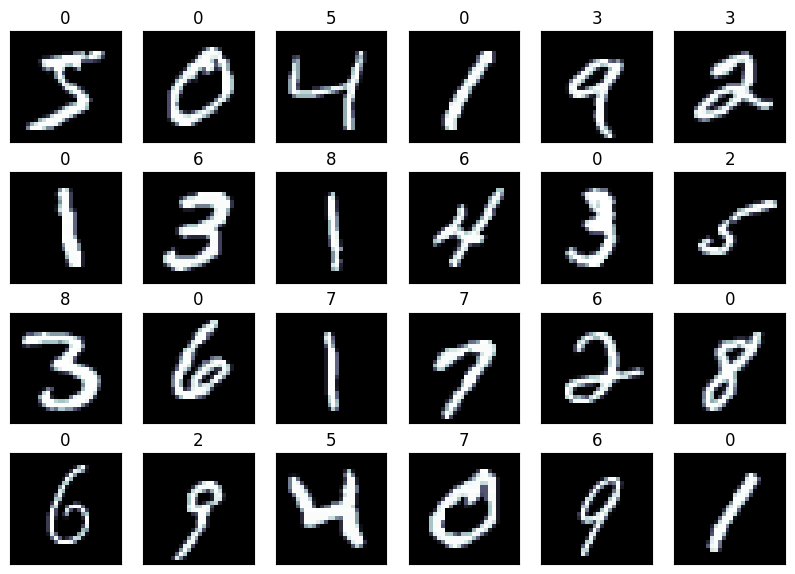

In [31]:
plt.figure(figsize=(10, 7))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_train[i][0].reshape(28, 28), cmap = plt.cm.bone)
    plt.title(model(data_train[i][0]).detach().argmax(axis = 1).item())

## Training the model

Now we can actually train the model. We'll need two things for that:
* The *loss* function - the function that we want to minimize
* The *optimizer* - a function that uses the gradient to make one optimization step

Note:
* `torch.nn.NLLLoss` is the cross-entropy loss function which takes as input a probability distribution
* `torch.nn.CrossEntropyLoss` is the cross-netropy loss function, which only takes as inputs class weights (i. e. they don't need to sum up to 1)

In other words, `CrossEntropyLoss` combines `NLLLoss` and `Softmax`.

We will use the ADAM optimizer.

In [32]:
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10

To train the model we will use the `DataLoader`. We will train in mini-batches, which means that we will split the datset into smaller batches, calculate the average loss function for the whole batch and then use it to make one optimization step. One epoch then means using the whole training dataset once (which includes many optimization steps).

Let us define 3 functions needed to train the model:

In [33]:
def calculate_accuracy(model, dataloader):
    num_correct = 0
    
    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    accuracy = num_correct / len(dataloader.dataset)
    return accuracy

In [34]:
def calculate_loss_accuracy(model, dataloader, loss_fn):
    loss = 0
    num_correct = 0
    
    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= len(dataloader)
    accuracy = num_correct / len(dataloader.dataset)
    return loss, accuracy

In [35]:
def train_model(model, loss_fn, optimizer, epochs, dataloader_train, dataloader_test, early_stopper = None, log_period = 10000):
    for epoch in range(epochs):
        processed_since_log = 0
        for batch, (X, y) in enumerate(dataloader_train):
            model.train()
            pred = model(X)
            loss = loss_fn(pred, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            processed_since_log += dataloader_train.batch_size

            if processed_since_log >= log_period:
                current = min((batch + 1) * dataloader_train.batch_size, len(data_train))
                loss = loss.item()
                model.eval()
                train_acc = calculate_accuracy(model, dataloader_train)
                test_loss, test_acc = calculate_loss_accuracy(model, dataloader_test, loss_fn)
                print(f"train loss: {loss:>7f}  test loss: {test_loss:>7f}  train accuracy: {train_acc:>3f}  test accuracy: {test_acc:>3f}  [sample {current:>5d}/{len(data_train):>5d}] [epoch {epoch+1:>2d}/{epochs:>2d}]")
                processed_since_log -= log_period

In [36]:
train_model(model, loss_fn, optimizer, epochs, dataloader_train, dataloader_test)

train loss: -0.820598  test loss: -0.843690  train accuracy: 0.888167  test accuracy: 0.891600  [sample 10000/60000] [epoch  1/10]
train loss: -0.832420  test loss: -0.884470  train accuracy: 0.907317  test accuracy: 0.910700  [sample 20000/60000] [epoch  1/10]
train loss: -0.942341  test loss: -0.903585  train accuracy: 0.920800  test accuracy: 0.922700  [sample 30000/60000] [epoch  1/10]
train loss: -0.896142  test loss: -0.909049  train accuracy: 0.923617  test accuracy: 0.927000  [sample 40000/60000] [epoch  1/10]
train loss: -0.855220  test loss: -0.919209  train accuracy: 0.933467  test accuracy: 0.931700  [sample 50000/60000] [epoch  1/10]
train loss: -0.908602  test loss: -0.924429  train accuracy: 0.937567  test accuracy: 0.936400  [sample 60000/60000] [epoch  1/10]
train loss: -0.952947  test loss: -0.927400  train accuracy: 0.940683  test accuracy: 0.939500  [sample 10000/60000] [epoch  2/10]
train loss: -0.889976  test loss: -0.929792  train accuracy: 0.944050  test accurac

### Evaluating the model

To evaluate the model on the test set, we can reuse the previously defined functions.

In [37]:
model.eval()
test_loss, test_acc = calculate_loss_accuracy(model, dataloader_test, loss_fn)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: -0.9671957495808602
Test accuracy: 0.9703


If we need the "raw" output values, we may again just use the model as a function:

In [38]:
predictions = model(data_test[0][0])
print('Prediction shape:', predictions.shape)
print('Probablity of the first image being a zero:', predictions[0, 0].item())

Prediction shape: torch.Size([1, 10])
Probablity of the first image being a zero: 1.321598608328145e-09


To obtain actual class predictions, we will use the `torch.argmax` function to find out which digit has the highest probability:

In [39]:
Y_pred = predictions.detach().argmax(dim = 1)
print('Probabilities for the first image:', predictions.detach())
print('Most likely label for the first image:', Y_pred[0].item())

Probabilities for the first image: tensor([[1.3216e-09, 1.0896e-13, 1.1279e-09, 1.2137e-07, 6.7669e-13, 1.9098e-09,
         7.4296e-17, 1.0000e+00, 5.7948e-09, 5.8476e-08]])
Most likely label for the first image: 7


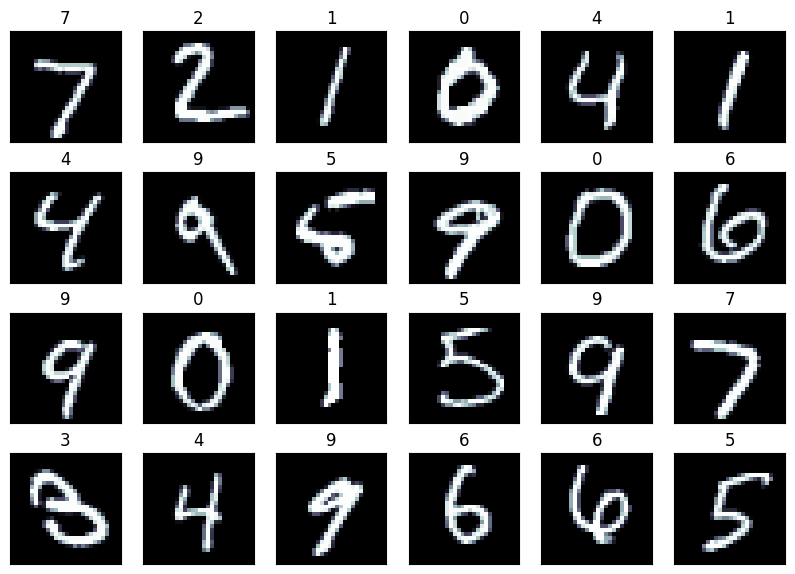

In [40]:
plt.figure(figsize=(10, 7))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_test[i][0].reshape(28, 28), cmap = plt.cm.bone)
    plt.title(model(data_test[i][0]).detach().argmax(axis = 1).item())

## Task 3 - Creating the model manually

Let's again define the basic properties of the model:

In [41]:
batch_size = 50
hidden_layer_width = 100
output_width = 10
learning_rate = 0.01
epochs = 10
loss_fn = nn.CrossEntropyLoss()

Let's define the parameters we will need for a neural network with one hidden layer with 100 neurons:

In [42]:
W1 = (0.1 * torch.randn((data_train[0][0].shape[1] * data_train[0][0].shape[2], hidden_layer_width))).clone().requires_grad_(True)
b1 = torch.zeros((hidden_layer_width,), requires_grad = True)
W2 = (0.1 * torch.randn((hidden_layer_width, output_width))).clone().requires_grad_(True)
b2 = torch.zeros((output_width,), requires_grad = True)

Let's define the forward pass of the neural net in a function:

In [43]:
def predict(inputs):
    inputs_flat = torch.nn.Flatten()(inputs)
    output_1 = torch.tanh(inputs_flat.matmul(W1).add(b1))
    output_2 = torch.nn.Softmax(dim = 1)(output_1.matmul(W2).add(b2))
    return output_2

Let's train the model:

In [44]:
log_period = 10000

for epoch in range(epochs):
    processed_since_log = 0
    for batch, (X, y) in enumerate(dataloader_train):
        pred = predict(X)
        loss = loss_fn(pred, y)
        loss.backward()

        for variable in [W1, b1, W2, b2]:
            with torch.no_grad():
                variable -= variable.grad * learning_rate
            variable.grad = None

        processed_since_log += dataloader_train.batch_size

        if processed_since_log >= log_period:
            current = min((batch + 1) * dataloader_train.batch_size, len(data_train))
            loss = loss.item()
            train_acc = calculate_accuracy(predict, dataloader_train)
            test_loss, test_acc = calculate_loss_accuracy(predict, dataloader_test, loss_fn)
            print(f"train loss: {loss:>7f}  test loss: {test_loss:>7f}  train accuracy: {train_acc:>3f}  test accuracy: {test_acc:>3f}  [sample {current:>5d}/{len(data_train):>5d}] [epoch {epoch+1:>2d}/{epochs:>2d}]")
            processed_since_log -= log_period

train loss: 2.296718  test loss: 2.281255  train accuracy: 0.212183  test accuracy: 0.218000  [sample 10000/60000] [epoch  1/10]
train loss: 2.235213  test loss: 2.240589  train accuracy: 0.289083  test accuracy: 0.292900  [sample 20000/60000] [epoch  1/10]
train loss: 2.133105  test loss: 2.191676  train accuracy: 0.339917  test accuracy: 0.341000  [sample 30000/60000] [epoch  1/10]
train loss: 2.149016  test loss: 2.138944  train accuracy: 0.407983  test accuracy: 0.407000  [sample 40000/60000] [epoch  1/10]
train loss: 2.047685  test loss: 2.085823  train accuracy: 0.477417  test accuracy: 0.480200  [sample 50000/60000] [epoch  1/10]
train loss: 2.132239  test loss: 2.036835  train accuracy: 0.555750  test accuracy: 0.562200  [sample 60000/60000] [epoch  1/10]
train loss: 2.002693  test loss: 1.986402  train accuracy: 0.603283  test accuracy: 0.611100  [sample 10000/60000] [epoch  2/10]
train loss: 1.884218  test loss: 1.942651  train accuracy: 0.631283  test accuracy: 0.637600  [sa

## Training (hyper-)parameters

In the previous examples we just set the various hyper-parameters of the network semi-randomly. Let's now take a look at them and their possible values.

### Network architecture

- Number of layers
- Layer widths
- activation functions
    - linear
    - tanh
    - sigmoid
    - hard sigmoid
    - relu
    - selu
    - softmax

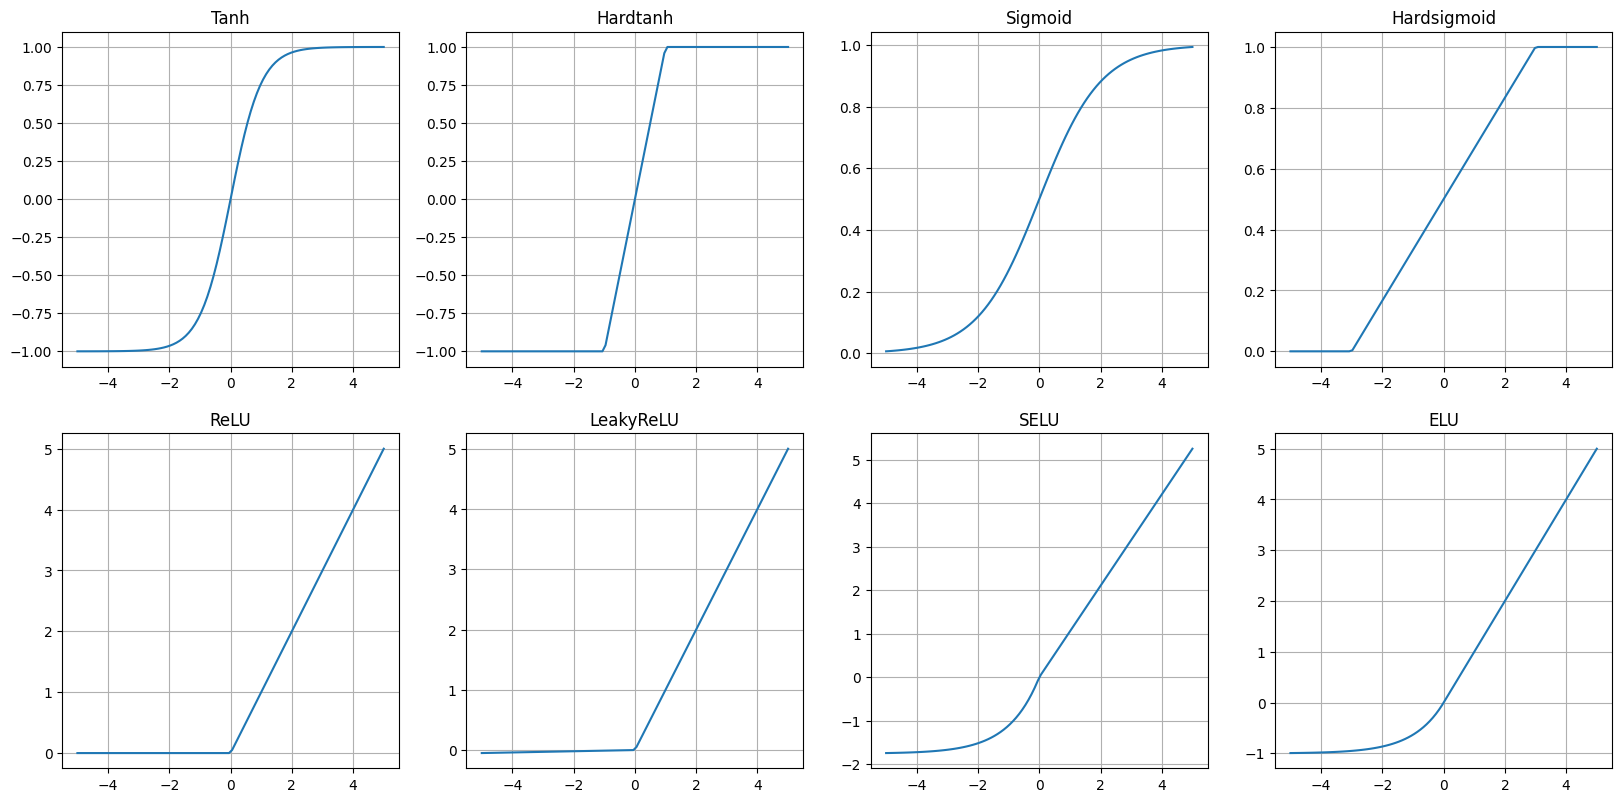

In [45]:
plt.figure(figsize=(20, 20))
i = 1
for activationFunction in [nn.Tanh(), nn.Hardtanh(), nn.Sigmoid(), nn.Hardsigmoid(), nn.ReLU(), nn.LeakyReLU(), nn.SELU(), nn.ELU()]:
    plt.subplot(4, 4, i)
    i += 1
    plt.grid(True)
    xs = torch.linspace(-5, 5, 100);
    ys = activationFunction(xs)
    plt.plot(xs, ys)
    plt.title(type(activationFunction).__name__)

## Loss functions

- Mean square error
    $$ \operatorname{MSE}=\frac{1}{n}\sum_{i=1}^n(Y_i-\hat{Y_i})^2. $$
- Hinge
    $$ \operatorname{Hinge} = \sum_{i=1}^K \max(0, 1- Y_i \cdot \hat{Y_i}) $$
- Cross-entropy
    $$ \operatorname{crossentropy} = - \sum_{i=1}^K Y_i \cdot \log(\hat{Y_i}) $$

## Optimization algorithms

- SGD
- RMSProp
- Adagrad
- Adam
- Adadelta
- Adamax
- Nadam
- AdamW

### Learning schedule

We may optionally add a so-called weight decay to the optimization algorithm. This means that the learning rate will become smaller as we train. For example:

In [46]:
initial_learning_rate = 0.01
batch_count = 64
optimizer = torch.optim.SGD(model.parameters(), weight_decay=0.001)

More advanced algorithms such as AdamW have weight decay built-in.

## Using the training dataset

We can set 2 ways in which the training dataset is used:
- Epochs: How many times we loop over the whole dataset
- Batching: Using the dataset not sample-by-sample but in batches

# Task 4

Try to modify the previously defined model on MNIST to obtain the best possible results by tuning its hyper-parameters.

## Solution

In [47]:
model = nn.Sequential()
model.append(nn.Flatten())
model.append(nn.Linear(data_train.data.shape[1] * data_train.data.shape[2], 256))
model.append(nn.Tanh())
model.append(nn.Linear(256, 128))
model.append(nn.Tanh())
model.append(nn.Linear(128, 10))

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10

In [49]:
train_model(model, loss_fn, optimizer, epochs, dataloader_train, dataloader_test)

train loss: 0.242106  test loss: 0.288315  train accuracy: 0.910733  test accuracy: 0.914600  [sample 10000/60000] [epoch  1/10]
train loss: 0.433957  test loss: 0.235900  train accuracy: 0.930700  test accuracy: 0.930000  [sample 20000/60000] [epoch  1/10]
train loss: 0.243737  test loss: 0.218875  train accuracy: 0.937583  test accuracy: 0.936200  [sample 30000/60000] [epoch  1/10]
train loss: 0.196528  test loss: 0.200857  train accuracy: 0.939083  test accuracy: 0.938900  [sample 40000/60000] [epoch  1/10]
train loss: 0.113291  test loss: 0.175792  train accuracy: 0.949967  test accuracy: 0.948400  [sample 50000/60000] [epoch  1/10]
train loss: 0.275778  test loss: 0.152720  train accuracy: 0.958117  test accuracy: 0.953900  [sample 60000/60000] [epoch  1/10]
train loss: 0.231096  test loss: 0.157614  train accuracy: 0.955917  test accuracy: 0.953000  [sample 10000/60000] [epoch  2/10]
train loss: 0.217140  test loss: 0.139104  train accuracy: 0.962317  test accuracy: 0.958000  [sa

In [50]:
model.eval()
test_loss, test_acc = calculate_loss_accuracy(model, dataloader_test, loss_fn)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.08310719113709637
Test accuracy: 0.9766
